In [5]:
using Pkg
Pkg.activate(".")

  Activating project at `~/SCDC/testSI(S)`


In [6]:
using Graphs
using JLD2, CSV, DataFrames, NPZ
using StatsBase
using SmallCouplingDynamicCavity
using PyCall
using Random
import PyPlot as plt
using Statistics
using LaTeXStrings

In [7]:
# Define the saving structure, in which the results will be saved
struct SaveStruct
    s::Int
    ε_autoinf::Float64
    maxiter::Union{Int,Array{Int}}
    damp::Union{Float64,Array{Float64}}
    μ_cutoff::Float64
    fpn::Float64
    n_iter_nc::Int
    damp_nc::Float64
    fMAP_true::Float64

    SaveStruct(s) = new(s, 0.0, 0, 0.0, 0.0, 0.0, 0, 0.0, 0.0)
    SaveStruct(s, ε_autoinf, maxiter, damp, μ_cutoff, fpn, n_iter_nc, damp_nc, fMAP_true) = new(s, ε_autoinf, maxiter, damp, μ_cutoff, fpn, n_iter_nc, damp_nc, fMAP_true)
end

to_rgba(col, alpha) = plt.matplotlib.colors.to_rgba(col, alpha)

function meshgrid_lin(x, y, dx, dy)
    nx = length(x)+1
    ny = length(y)+1
    X = zeros(ny,nx)
    Y = zeros(ny,nx)
    for j in 1:nx-1
        X[:,j] .= x[j]-dx/2
    end
    X[:,nx] .= x[nx-1]+dx/2
    
    for i in 1:ny-1
        Y[i,:] .= y[i]-dy/2
    end
    Y[ny,:] .= y[ny-1]+dy/2
    return X, Y
end

meshgrid_lin (generic function with 1 method)

# Varying lambda, sigma

## Proximity random graphs

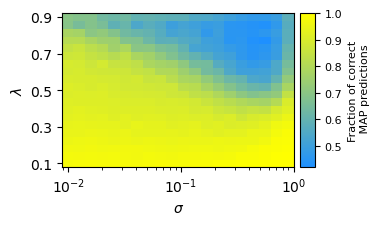

In [8]:
n_sample = 30
sims = collect(1:n_sample)

# Parameters
T = 15
NV = 300
lmax = round(sqrt(1.8/NV), digits=3)
n_sr = 2
γ = n_sr/NV
λs = round.(collect(range(0.1, 0.9, length=20)), digits=3)
σs = round.(10 .^ (collect(range(log10(0.01), log10(0.9), length=20))), digits=3)
λ_σs = collect(Iterators.product(λs, σs))
nobs = floor(Int, .6*NV)

tobs = floor(Int, T/2)


############### SCDC #############################
fMAP_trues_m = zeros(length(λs), length(σs))

for (idx, (λ₀,σ₀)) in enumerate(λ_σs)
    save_vec = JLD2.load_object("logs/test_SIS/var_lambda_sigma/N-$(NV)_lmax-$(lmax)_tlim-$(T)_nsrc-$(n_sr)_nobs-$(nobs)/lam_$(λ₀)_sigma_$(σ₀)/optim_pars_rand_geom.jld2")
    fMAP_trues = [save_struct.fMAP_true for save_struct in save_vec]
    
    filter!(x->x ≠ 0.0, fMAP_trues)
    
    fMAP_trues_m[idx] = mean(fMAP_trues)
end
##################################################



################## Plot fMAP_true  ####################
fig, ax = plt.subplots(figsize=(3.4, 2))
rcParams = PyDict(plt.matplotlib["rcParams"])
rcParams["font.size"] = 8  #9 18

# Custom color gradient
color1 = "dodgerblue"  # Starting color
color2 = "yellow"      # Ending color
# Create a colormap using LinearSegmentedColormap
cm = plt.matplotlib.colors.LinearSegmentedColormap.from_list("custom_cmap", [color1, color2])

## Heatmap ##
# Define axes
y_edges = λs  # Edges for x-axis (0.5 to NV + 0.5)
dy = y_edges[2] - y_edges[1]
x_edges_exp = collect(range(log10(0.01), log10(0.9), length=20)) # Edges for y-axis (0 to T)
dx = x_edges_exp[2] - x_edges_exp[1]
# Create X, Y coordinate matrices
X, Y = meshgrid_lin(x_edges_exp, y_edges, dx, dy)
# Plot heatmap
p = ax.pcolor(10 .^ X, Y, fMAP_trues_m, cmap=cm, vmin=minimum(fMAP_trues_m),  vmax=1, edgecolors="none", shading="flat")
ax.set_ylabel(L"$\lambda$") 
ax.set_xlabel(L"$\sigma$")
ax.set_ylim(y_edges[1]-dy/2, y_edges[end]+dy/2)
ax.set_yticks(.1:.2:.9)
ax.set_xlim(10 .^ (x_edges_exp[1]-dx/2), 10 .^ (x_edges_exp[end]+dx/2))
ax.set_xscale("log")

#ax.set_yscale("log")
####################################################

# Add colorbars with adjusted width and position
cbar = fig.colorbar(p, ax=ax, orientation="vertical", fraction=0.1, pad=.02, aspect=10, drawedges=false)
cbar.set_label("Fraction of correct\n MAP predictions")

fig.savefig("SIS_heatmap_inference.png", format="png", bbox_inches="tight", dpi=2000)